In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp

In [2]:
# PARAMs
p = 0.05
discount = 0.95
alpha = 0.2
epsilon = 0.1
max_episode = 500
max_step = 500

In [3]:
class state:
    def __init__(self, content):
        self.content = np.array(content)
        self.Q = [0,0,0,0]
        self.policy = 0
        self.e = np.zeros(4)
        self.V = 0
        self.H = [0,0,0,0]

In [4]:
# States Space
S_space = []
N = 16  
for i in range(16):
    num = "{0:04b}".format(i)
    S_space.append(state([int(i) for i in num]))

# Action Space
A = np.array([[0,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])

# for i in range(len(S_space)):
#     print(S_space[i].content)

In [5]:
# Connectivity Matrix
C = np.array([[0,0,-1,0],
               [1,0,-1,-1],
               [0,1,0,0],
               [-1,1,1,0]])

# v_bar mapping
def bar(vec):
    for i in range(len(vec)):
        if vec[i] > 0:          # map greater than 0 to 1
            vec[i] = 1
        else:                   # map smaller or equal to 0 to 0
            vec[i] = 0
    return vec

# ⊕ component wise XOR
def mod2add(a, b):
    result = []
    for i, j in zip(a, b):
        if i==j:
            result.append(0)
        else:
            result.append(1)
    return np.array(result)

In [6]:
# Reward
def Reward(state, action, next_state):
    return np.sum(next_state.content)*5 - np.sum(np.absolute(action))

# Epsilon Greedy
def Egreedy(state, epsilon):
    num = np.random.uniform(0,1)
    action = 0
    if(num < epsilon):      # random
        action =  np.random.randint(4)
    else:                   # greedy
        action =  np.argmax(state.Q)
    return action

In [7]:
# State Transition
def get_next_index(state, action, prob):
    nk = np.random.choice(2, size=4, p=[1-prob, prob])
    next = mod2add( mod2add(bar(np.matmul(C, state.content)), A[action]), nk)
    return next[0]*8+next[1]*4+next[2]*2+next[3]

# Tests
# s = S_space[7]
# a = A[3]
# print(s.content, a)
# print(get_next(s, a, 0.05))

In [8]:
def SARSA(S_space, param):
    p = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    max_step = param[4]
    max_episode = param[5]
    accu_reward = []

    for i in range(max_episode):
        sum_reward = 0
        # Initialize s, a
        state = S_space[np.random.randint(16)]
        action = Egreedy(state, epsil)
         # For Each Episode
        for i in range(max_step):
            # s', R
            nxt_state = S_space[get_next_index(state, action, p)]
            R = Reward(state, action, nxt_state)
            # Q(s,a)
            Q = state.Q[action]
            # Q(s',a')
            nxt_action = Egreedy(nxt_state, epsil)
            Q_next = nxt_state.Q[nxt_action]
            # Update Q(s,a)
            state.Q[action] = Q + alpha* (R + gamma*Q_next - Q)
            # s-s', a-a'
            state = nxt_state
            action = nxt_action
            # Accu R
            sum_reward += R

        accu_reward.append(sum_reward)
        # Update Policy
        for s in S_space:
            s.policy = np.argmax(s.Q)
    return accu_reward


In [9]:
def QLearning(S_space, param):
    p = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    max_step = param[4]
    max_episode = param[5]
    accu_reward = []

    for i in range(max_episode):
        sum_reward = 0
        # Initialize s
        state = S_space[np.random.randint(16)]

         # For Each Episode
        for i in range(max_step):
            # a
            action = Egreedy(state, epsil)
            # s', R
            nxt_state = S_space[get_next_index(state, action, p)]
            R = Reward(state, action, nxt_state)
            # Q(s,a)
            Q = state.Q[action]
            # maxQ(s',a')
            Q_next = max(nxt_state.Q)
            # Update Q(s,a)
            state.Q[action] = Q + alpha* (R + gamma*Q_next - Q)
            # s-s'
            state = nxt_state
            # Accu R
            sum_reward += R

        accu_reward.append(sum_reward)
        # Update Policy
        for s in S_space:
            s.policy = np.argmax(s.Q)
    return accu_reward


In [10]:
def SARSA_lambda(S_space, param, lamda):
    p = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    max_step = param[4]
    max_episode = param[5]
    accu_reward = []

    for i in range(max_episode):
        # Initialize s, a
        state = S_space[np.random.randint(16)]
        action = Egreedy(state, epsil)
        # Initialize e(s,a) = 0
        for s in S_space:
            s.e = np.zeros(4)
        # Inizilize accu reward
        sum_reward = 0

         # For Each Episode
        for i in range(max_step):
            # Take a, observe s', R
            nxt_state = S_space[get_next_index(state, action, p)]
            R = Reward(state, action, nxt_state)
            sum_reward += R
            # Q(s,a)
            Q = state.Q[action]
            # Q(s',a')
            nxt_action = Egreedy(nxt_state, epsil)
            Q_next = nxt_state.Q[nxt_action]
            # 
            delta = R + gamma*Q_next - Q
            state.e[action] = state.e[action] + 1
            # for all s, a:
            for s in S_space:
                for a in range(len(A)):
                    s.Q[a] = s.Q[a] + alpha * delta * s.e[a]
                    s.e[a] = gamma * lamda * s.e[a]
            # s-s', a-a'
            state = nxt_state
            action = nxt_action

        # Record Accu Reward
        accu_reward.append(sum_reward)
        # Update Policy
        for s in S_space:
            s.policy = np.argmax(s.Q)
    return accu_reward

In [11]:
# Action Selection
def PSelect(state):
    sum = 0
    prob_dist = []
    for a in range(len(A)):
        sum += exp(state.H[a])
    for a in range(len(A)):
        prob_dist.append(exp(state.H[a]) / sum)
    return prob_dist

# Actor-Critic
def ActorCritic(S_space, param, beta):
    p = param[0]
    gamma = param[1]
    alpha = param[2]
    epsil = param[3]
    max_step = param[4]
    max_episode = param[5]
    accu_reward = []

    for i in range(max_episode):
        # Initialize s
        state = S_space[np.random.randint(16)]
        # Inizilize accu reward
        sum_reward = 0

         # For Each Episode
        for i in range(max_step):
            # Select A
            prob = PSelect(state)
            action = np.random.choice([0,1,2,3], p=prob)
            # Take A, observe S', R
            nxt_state = S_space[get_next_index(state, action, p)]
            R = Reward(state, action, nxt_state)
            sum_reward += R
            # Update V, H
            delta = R + gamma * nxt_state.V - state.V
            state.V = state.V + alpha * delta
            state.H[action] = state.H[action] + beta * delta * (1 - prob[action])
            # S'->S
            state = nxt_state

        accu_reward.append(sum_reward)
    # Update Policy
    for s in S_space:
        s.policy = np.argmax(PSelect(s))

    return accu_reward

In [12]:
# Parameters
p = 0.05
gamma = 0.95
alpha = 0.2
epsilon = 0.1
max_step = 500
max_episode = 500
param = [p, gamma, alpha, epsilon, max_step, max_episode]
lamda = 0.95
beta = 0.05
max_run = 1


def run(algorithm):
    sum = np.zeros(max_episode)
    for i in range(max_run):
        states = S_space.copy()
        if algorithm == 0:      # SARSA
            
            accu_reward = SARSA(states, param)
        elif algorithm == 1:    # Q_Learning
            
            accu_reward = QLearning(states, param)
        elif algorithm == 2:    # SARSA(λ)
            
            accu_reward = SARSA_lambda(states, param, lamda)   
        elif algorithm == 3:
            
            accu_reward = ActorCritic(S_space, param, beta)
        sum += accu_reward
        # Print Policy
        policy = []
        for s in S_space:
            policy.append(s.policy+1)
        print(np.array(policy))
    return sum


# SARSA(λ)
# states = S_space.copy()
# accu_reward = SARSA_lambda(states, param, lamda)
# sum_sarsa_lamda = accu_reward

In [13]:
print("SARSA")
sum_sarsa = run(0)
print("Q")
sum_ql = run(1)
print("Slam")
sum_sarsa_lamda = run(2)
print("AC")
sum_acritic = run(3)

SARSA
[2 2 2 2 2 2 2 2 1 1 1 2 1 2 1 2]
Q
[2 2 2 2 2 2 2 2 1 1 1 2 1 2 2 2]
Slam
[3 2 2 2 4 2 2 1 4 1 2 1 4 1 2 1]
AC
[2 2 2 2 2 2 2 2 4 2 2 3 4 2 2 2]


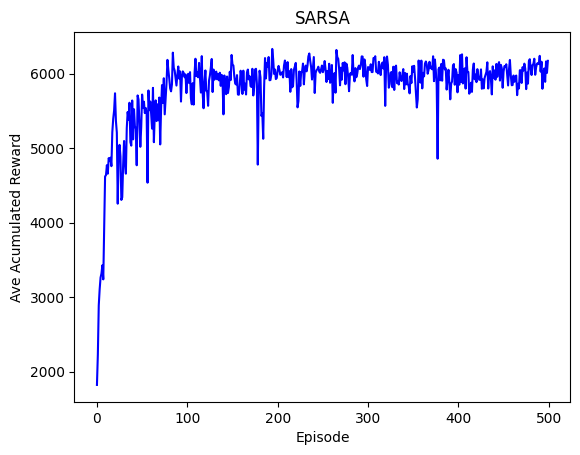

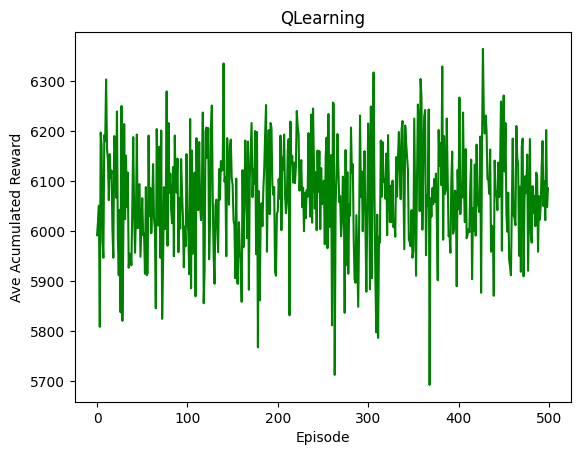

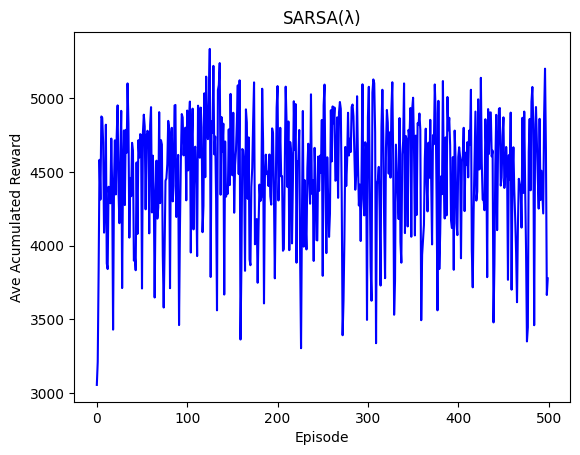

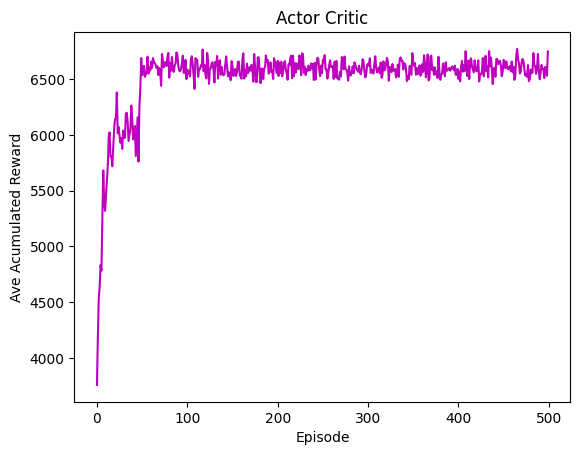

In [14]:
plt.plot(np.arange(len(sum_sarsa)),sum_sarsa/max_run, 'b-', label="SARSA")
plt.title("SARSA")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()
plt.plot(np.arange(len(sum_ql)),sum_ql/max_run, 'g-', label="QLearning")
plt.title("QLearning")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()
plt.plot(np.arange(len(sum_sarsa_lamda)),sum_sarsa_lamda/max_run, 'b-', label="SARSA(λ)")
plt.title("SARSA(λ)")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()
plt.plot(np.arange(len(sum_acritic)),sum_acritic/max_run, 'm-', label="Actor Critic")
plt.title("Actor Critic")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()

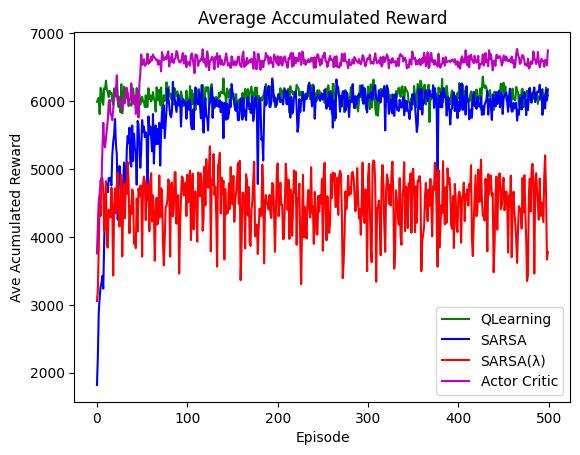

In [15]:
plt.plot(np.arange(len(sum_ql)),sum_ql/max_run, 'g-', label="QLearning")
plt.plot(np.arange(len(sum_sarsa)),sum_sarsa/max_run, 'b-', label="SARSA")
plt.plot(np.arange(len(sum_sarsa_lamda)),sum_sarsa_lamda/max_run, 'r-', label="SARSA(λ)")
plt.plot(np.arange(len(sum_acritic)),sum_acritic/max_run, 'm-', label="Actor Critic")
plt.legend()
plt.title("Average Accumulated Reward")
plt.xlabel("Episode")
plt.ylabel("Ave Acumulated Reward")
plt.show()